In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from swing_decision_model import SDModel


The motivation for this project was an area that the Phillies wanted to investigate. The organization uses a swing decision grades model as one of the primary ways they evaluate hitters. These grades are meant to model the expected value of swinging or not swinging at a pitch based on the outcomes of similar pitches and situations. This is useful on a high-level basis to see if players on average are taking good plate approaches to deciding when to swing, and/or seeing the ball well in order to make a good decision.

However, something that is important in the player development realm is coaching players' to have good plate approaches, intelligently expecting and reacting to pitches based on the situation. The current ball-strike count is therefore an important element of evaluating swing decisions, and while it is intrinsically included in the model, there has not been any work done on how players differ in terms of their swing decisions given different counts.

Modeling this would provide value to the organization by allowing coaches to see if players' swing decisions are due to a general problem (eg predicting the ball's trajectory, general overaggressiveness) or situational factors, such as changing their approach with 2 strikes in an attempt to avoid strikeouts. Bayesian Hierarchical modeling is applicable to this situation where players will have varying numbers of pitches seen and swing decisions made, and it is important to gain an understanding of the uncertainty with which these vary. By fitting a linear model with different weights for each count situation, we can model the player's underlying swing decision skill (the intercept) and examine the effects of different counts.

### Data Setup

In [149]:
sd_data = pd.read_csv("swing_decisions_22.csv")
# cheese = cheese.iloc[100:120].reset_index(drop=True)
# cheese.store = pd.Categorical(cheese.store)
# cheese["store_code"] = cheese.store.cat.codes
players = sd_data["batter_id"]
sd_data = sd_data.sort_values("batter_id")

pitch_counts = sd_data.groupby(["batter_id", "batter_name"]).agg({"swing_decision":"count"}).sort_values("swing_decision").reset_index().rename(columns={"swing_decision":"pitches"})
sd_data_counted = sd_data.merge(pitch_counts, on=["batter_name","batter_id"])
qualified = sd_data_counted[sd_data_counted["pitches"] >= 300]["swing_decision"].astype("float")
sd_mean = qualified.mean()
sd_std = qualified.std()
sd_data_counted["swing_decision_normal"] = (sd_data["swing_decision"].astype("float")-sd_mean)/sd_std
sd_data_sample = sd_data_counted

In [150]:
player_idx = sd_data_sample.groupby('batter_id')
players = list(player_idx.groups.keys())
X_players = []
y_players = []
for player in players:
    df_player = player_idx.get_group(player)
    counts = pd.DataFrame({"intercept": np.ones(len(df_player))})
    counts["2_strikes"] = [1 if x in ["0-2", "1-2", "2-2", "3-2"] else 0 for x in df_player["count"]]
    counts["ahead"] = [1 if x in ["1-0", "2-1", "3-0", "3-1"] else 0 for x in df_player["count"]]
    counts["behind"] = [1 if x in ["0-1", "0-2", "1-2", "2-2"] else 0 for x in df_player["count"]]
    counts["neutral"] = [1 if x in ["0-0", "1-1", "2-1"] else 0 for x in df_player["count"]]
    counts["first"] = [1 if x == "0-0" else 0 for x in df_player["count"]]
    # counts = pd.get_dummies(sd_data_sample["count"])
    # counts.insert(0, "intercept", np.ones(len(counts)))
    column_names = counts.columns
    X_players.append(counts.to_numpy())
    y = df_player["swing_decision_normal"].to_numpy()
    y_players.append(y)

### Model

The model used here is similar to the linear model from the cheese problem, just without the log part, and using binary features that essentially encode the counts, grouping them by similar situations.

$y_i \sim \mathrm{N}(X_i\beta_i, \sigma^2 I)\\
\sigma^2 \propto 1/\sigma^2  \\
\beta_i \sim \mathrm{N}(\gamma, \sigma^2 \Lambda)  \\
\gamma \propto 1  \\
\Lambda \sim diag(\mathrm{IG}(1/2, 1/2))\\
$


The categories used are somewhat chosen due to trial and error after just one-hot encoding the counts seemed to be separating up the data a little too much. Essentially the way the X dataframe was constructed for this model is saying that there is a baseline swing decision skill (the intercept) and then depending on the type of count that the batter is in, that skill will be increased or decreased by a certain weight. The effect of the count is influenced by the identity of the player, hence the advantage of a hierarchical model, because e.g. some players might make better decisions than average in 2-strike counts.

In [151]:
swing_decision_model = SDModel(X_players, y_players, players, n_iter=2500, burn=1000)
swing_decision_model.fit()

100%|██████████| 3500/3500 [06:51<00:00,  8.51it/s]


In [152]:
y_pred_grouped = []
for i in range(len(X_players)):
    mean_betas = np.array([x[:,i] for x in swing_decision_model.traces["betas"]]).mean(axis=0)
    y_pred_grouped.append(np.array(X_players[i] @ np.array(mean_betas)))
    

In [153]:
y_pred = np.concatenate(y_pred_grouped).ravel()
y_flat = np.concatenate(y_players).ravel()

### Posterior Predictive Checks

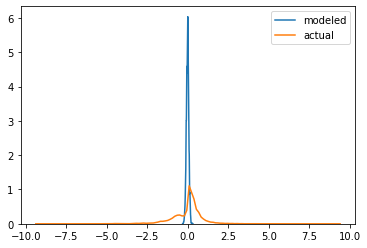

In [154]:
import numpy as np
import seaborn as sns
sns.kdeplot(np.array(y_pred), label="modeled")
sns.kdeplot(np.array(y_flat), label="actual")
plt.legend()

We can see in this figure that the modeled swing decisions are clustered much closer to zero than the actual observed values. This suggests that our model is relatively conservative in allowing extreme values.

(array([  6.,  11.,  50.,  65., 115.,  97.,  65.,  41.,  13.,   8.]),
 array([-0.1604761 , -0.13023017, -0.09998424, -0.0697383 , -0.03949237,
        -0.00924644,  0.02099949,  0.05124543,  0.08149136,  0.11173729,
         0.14198322]),
 <a list of 10 Patch objects>)

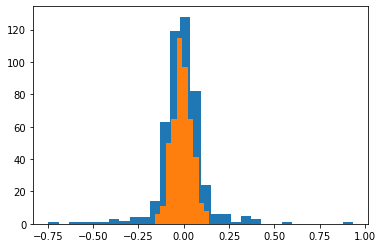

In [155]:
pred_means = []
actual_means = []
for i in (range(len(players))):
    pred_means.append(np.mean(y_pred_grouped[i]))
    actual_means.append(np.mean(y_players[i]))

plt.hist(actual_means, bins=30)
plt.hist(pred_means, bins=10)
# plt.plot(np.array([-.2, .2]), np.array([-.2,.2]), c="red")

Aggregating the predictions into player-level means gives slightly better results in terms of what a simulated dataset looks like

In [156]:
from scipy.stats import ttest_rel
ttest_rel(y_pred, y_flat)

Ttest_relResult(statistic=0.03607023722144403, pvalue=0.9712264180542226)

In [157]:
ttest_rel(actual_means, pred_means)

Ttest_relResult(statistic=0.3960296390205185, pvalue=0.6922628823069317)

We can see from a t-test that the simulated dataset is not very close to the actual one on a pitch-by-pitch level, but it performs somewhat better on the player level.

Let's plot each beta with mean and approximate 95% CI for each player. For these plots, the players are sorted from left to right based on pitches seen.

In [170]:
all_beta_data = pitch_counts.copy()
for beta in range(swing_decision_model.n_betas):
    col_name = column_names[beta]
    betas = swing_decision_model.traces["betas"][:,beta]
    
    beta_data = pd.DataFrame({f"{col_name}_mean":betas.mean(axis=0), f"{col_name}_std": np.std(betas, axis=0), "batter_id": players})
    all_beta_data = all_beta_data.merge(beta_data, on="batter_id")
all_beta_data = all_beta_data.sort_values("pitches")

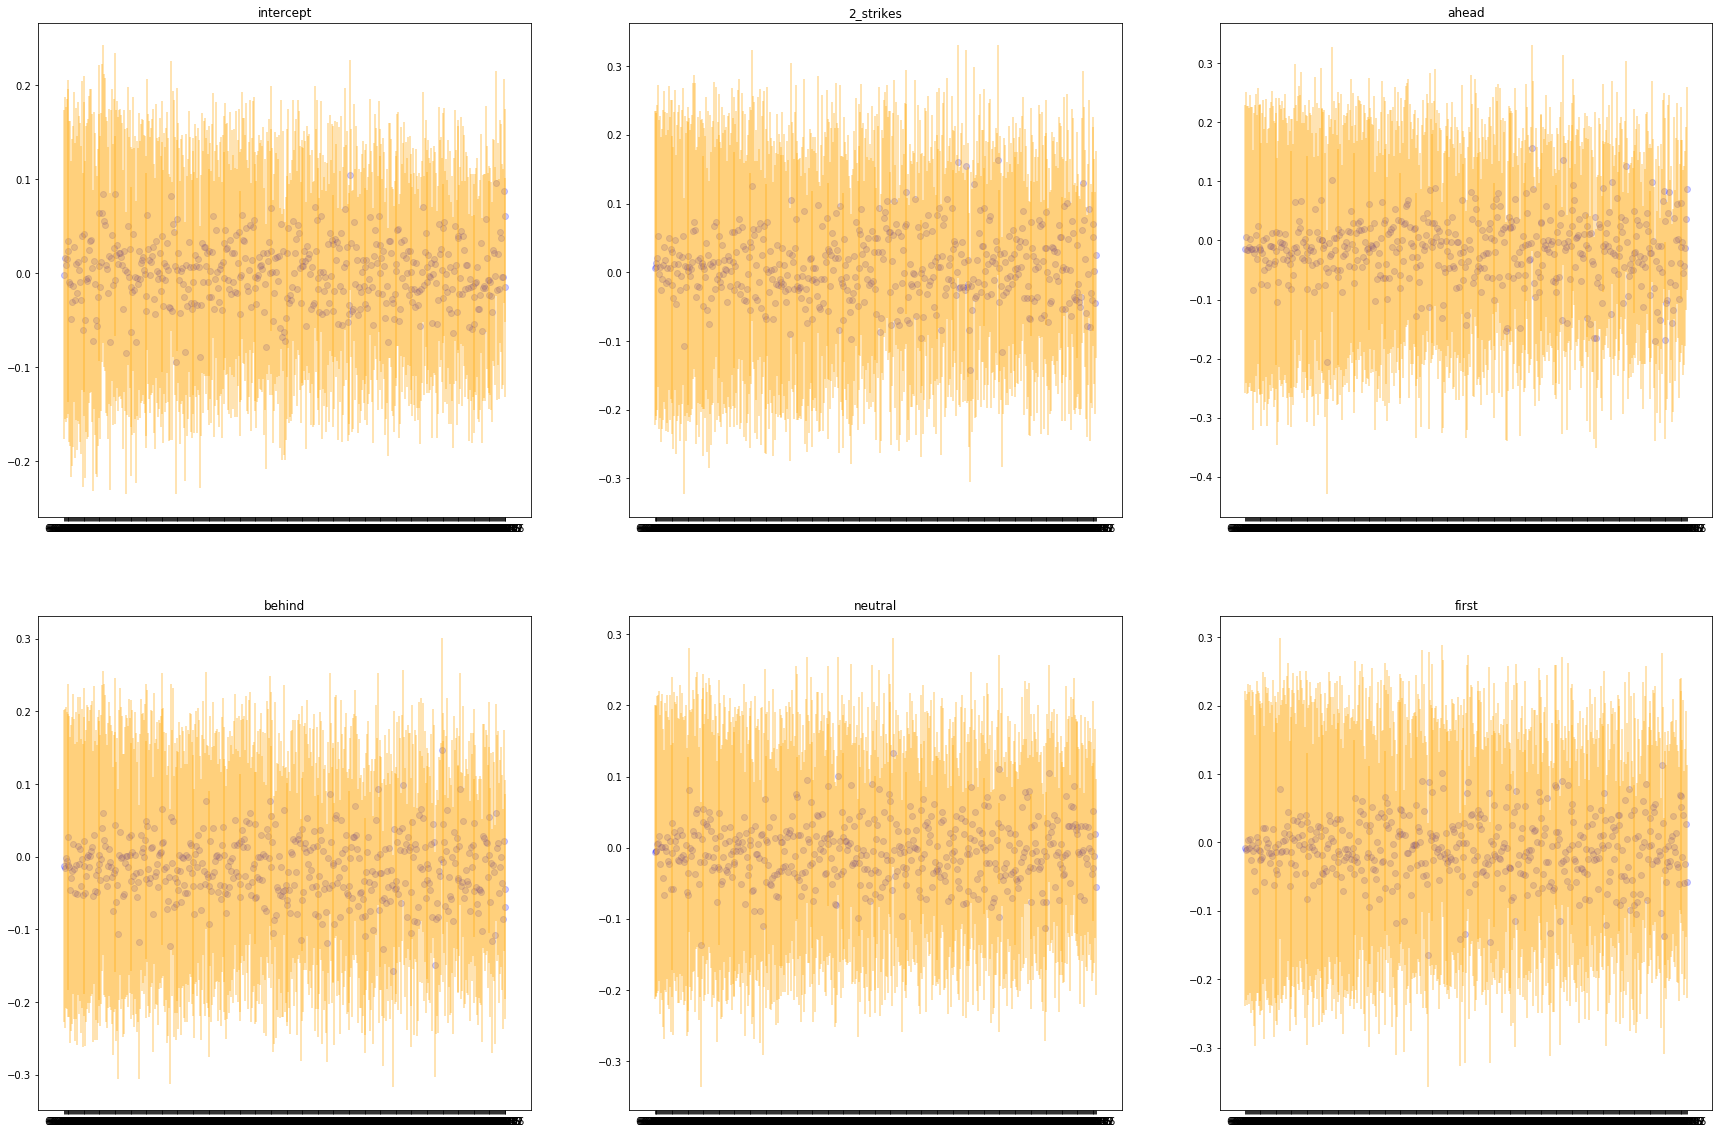

In [171]:
fig, _ = plt.subplots(2,3,figsize=(30,20))
axes = fig.get_axes()
for i in range(len(axes)):
    ax = axes[i]
    col_name = column_names[i]

    plt.sca(ax)
    plt.vlines(all_beta_data["batter_id"].astype('str'), all_beta_data[f"{col_name}_mean"]-1.96*all_beta_data[f"{col_name}_std"], all_beta_data[f"{col_name}_mean"]+1.96*all_beta_data[f"{col_name}_std"], color="orange", alpha=.4)
    plt.scatter(all_beta_data["batter_id"].astype('str'), all_beta_data[f"{col_name}_mean"], color="blue", alpha=.2)
    plt.title(column_names[i])

We can see from these plots that the spread of means gets somewhat greater as we move to the right (ie more pitches seen). However, it seems like  the uncertainty remains pretty consistent no matter what.

In [174]:
all_beta_data.sort_values("2_strikes_mean", ascending=True)

,batter_id,batter_name,pitches,intercept_mean,intercept_std,2_strikes_mean,2_strikes_std,ahead_mean,ahead_std,behind_mean,behind_std,neutral_mean,neutral_std,first_mean,first_std
336,657557,"DeJong, Paul",345,0.029850,0.063074,-0.142861,0.083008,0.045636,0.096563,0.004258,0.079564,0.013097,0.079703,-0.030327,0.093270
370,608369,"Seager, Corey",376,-0.016851,0.062475,-0.116567,0.085390,-0.040705,0.092956,-0.105065,0.080022,0.071397,0.078109,-0.017492,0.087003
31,663662,"Cameron, Daz",25,-0.071988,0.081666,-0.107745,0.109849,-0.035322,0.119393,-0.054215,0.102163,-0.020823,0.102533,-0.006127,0.112629
209,668731,"Baddoo, Akil",217,0.007764,0.066575,-0.096476,0.092796,-0.130887,0.099681,-0.000105,0.089699,0.088024,0.087150,0.101013,0.095573
283,467793,"Santana, Carlos",293,0.042836,0.064113,-0.095947,0.088051,0.032697,0.094814,0.086735,0.084555,0.053639,0.082396,-0.084096,0.094332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,679529,"Torkelson, Spencer",350,0.023433,0.061403,0.128823,0.086927,-0.015960,0.092281,-0.126408,0.082682,0.010847,0.078916,-0.013674,0.093706
456,663757,"Grisham, Trent",459,-0.041394,0.059529,0.130192,0.082593,0.038183,0.087002,-0.115994,0.078995,-0.003737,0.075182,-0.006000,0.085807
331,642708,"Rosario, Amed",343,0.046081,0.062784,0.154686,0.086376,-0.063659,0.090669,-0.023190,0.080222,-0.077162,0.082485,0.080983,0.090835
323,670032,"Lopez, Nicky",337,-0.036762,0.063662,0.160859,0.086540,-0.018963,0.094404,0.005960,0.083002,-0.047191,0.080925,-0.062923,0.088980


Based on looking at the table, it's interesting to look at the beta values for individual players. We can see, sorting by 2 strike means for example, that the model sees Paul DeJong as having an above average swing decision intercept but the weight applied with two strikes is very far in the negative, suggesting that Dejong makes much worse decisions than the average player with 2 strikes than in other counts. We can see that a lot of the players at the extremes have seen more pitches, which is somewhat encouraging that the model is shrinking smaller sample sizes back to the mean, and for players with fewer pitches (eg Daz Cameron in this table) we see larger uncertainty values.  It would be interesting to see how this plays out and compare these estimates to results in a more robust way.